In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from connectome import Connectome
from connectome_network import ConnectomeNetwork
from connectome_types import SynapseSide, cell_types, ClfType, m_types, CONNECTOME_SYN_TABLE_PATH
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
clf_type_space = [e.value for e in ClfType]

In [3]:
em_syn_df = pd.read_csv(CONNECTOME_SYN_TABLE_PATH)
print(len(em_syn_df))
em_syn_df.head()

13506902


,Unnamed: 0,id_,pre_id,post_id,dist_to_post_syn_soma,dist_to_pre_syn_soma,size,center_position,depth,pre_clf_type,pre_cell_type,pre_m_type,post_clf_type,post_cell_type,post_mtype_type
0,0,42727255,864691135939091253,864691134784325628,11.914092,-0.001000,1.096,[ 436552 1060520 887560],0.0,E,5P-ET,L6tall-a,E,6P-IT,L6tall-c
1,1,176815515,864691136106018009,864691134884743162,17.153281,49.730575,1.524,[744344 848240 630880],4.0,I,BC,DTC,E,6P-IT,L6short-a
2,2,176816501,864691136106018009,864691134884743162,9.309928,77.391179,0.444,[749436 853228 631360],4.0,I,BC,DTC,E,6P-IT,L6short-a
3,3,140956220,864691134885785594,864691134884743162,116.817573,98.393370,3.136,[667184 889672 641640],4.0,E,5P-IT,L5a,E,6P-IT,L6short-a
4,4,182281805,864691135610509831,864691134884743162,60.572679,12.589502,3.704,[754952 822448 623760],4.0,I,BC,PTC,E,6P-IT,L6short-a


### Synapse Dist to Soma

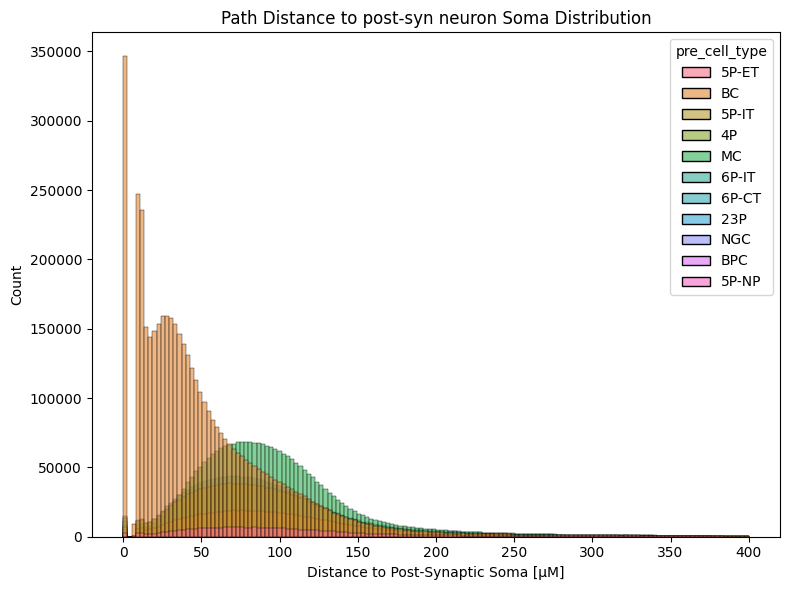

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=em_syn_df, x="dist_to_post_syn_soma", hue="pre_cell_type",bins=150,
             multiple="layer", alpha=0.6, binrange=(0, 400), ax=ax)
ax.set_title("Path Distance to post-syn neuron Soma Distribution");
ax.set_xlabel("Distance to Post-Synaptic Soma [µM]");ax.set_ylabel("Count")
plt.tight_layout();plt.show()
# TODO: 11 plots - per POST - syn type. 

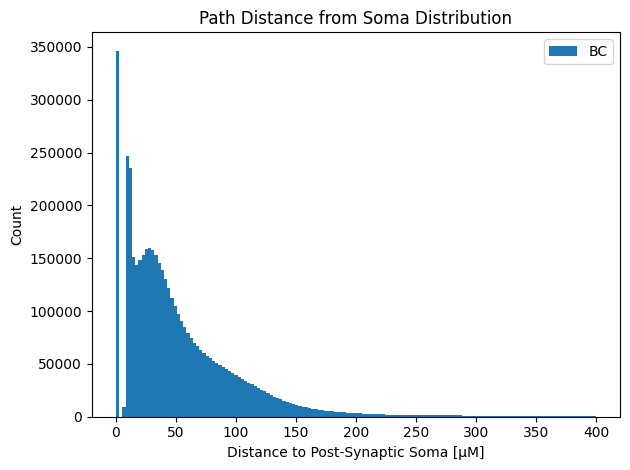

In [6]:
ax = em_syn_df[em_syn_df.pre_cell_type == 'BC']['dist_to_post_syn_soma'].plot.hist(
    bins=150,
    range=(0, 400),
    label='BC',
)

ax.set_title("Path Distance from Soma Distribution");ax.set_xlabel("Distance to Post-Synaptic Soma [µM]");ax.set_ylabel("Count")
ax.legend();plt.tight_layout();plt.show()
# sns.despine()

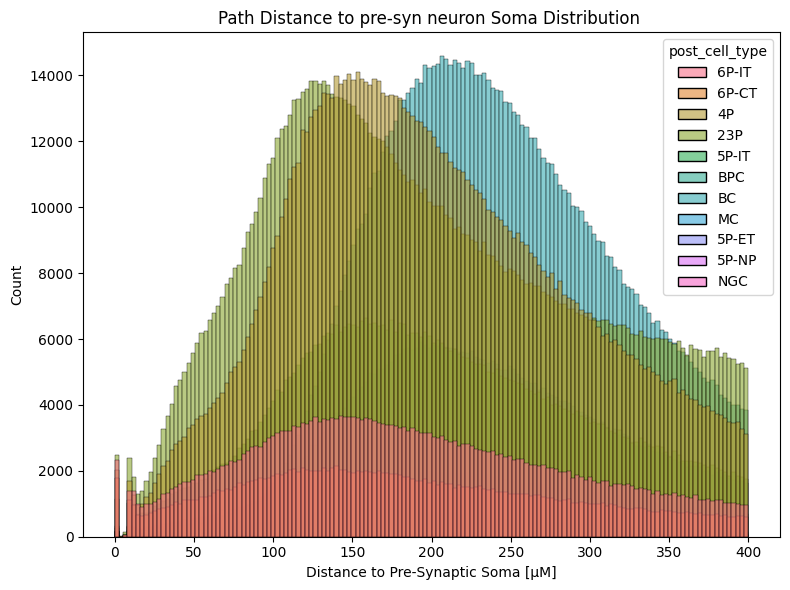

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=em_syn_df, x="dist_to_pre_syn_soma", hue="post_cell_type",bins=150,
             multiple="layer", alpha=0.6, binrange=(0, 400), ax=ax)
ax.set_title("Path Distance to pre-syn neuron Soma Distribution ");
ax.set_xlabel("Distance to Pre-Synaptic Soma [µM]");ax.set_ylabel("Count")
plt.tight_layout();plt.show()
# TODO: 11 plots - per POST - syn type. 

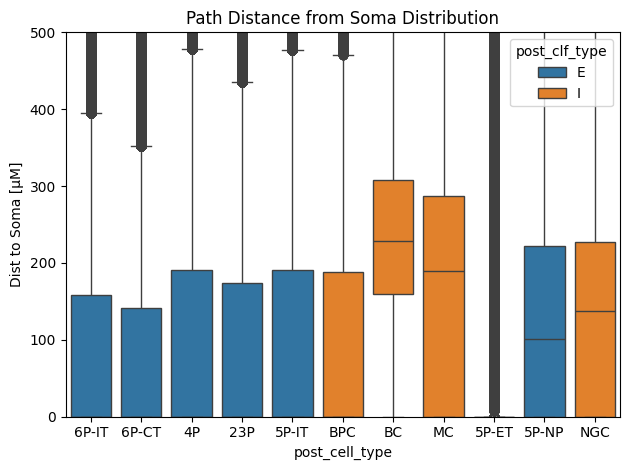

In [11]:
sns.boxplot(x="post_cell_type", y="dist_to_pre_syn_soma", hue="post_clf_type", data=em_syn_df)
plt.title("Path Distance from Soma Distribution")
plt.ylim(0, 500);plt.ylabel("Dist to Soma [µM]")
plt.tight_layout();plt.show()

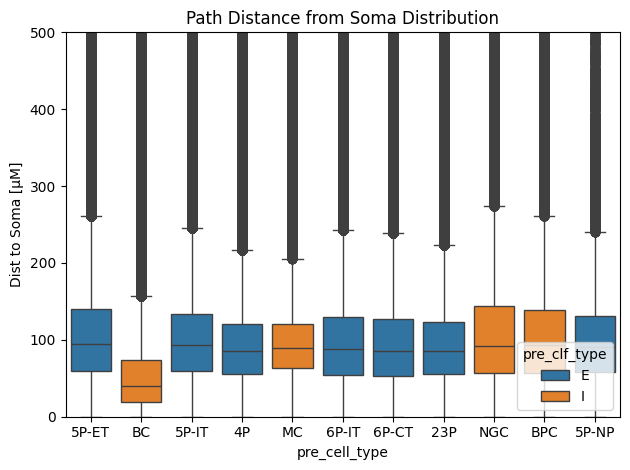

In [10]:
sns.boxplot(x="pre_cell_type", y="dist_to_post_syn_soma", hue="pre_clf_type", data=em_syn_df)
plt.title("Path Distance from Soma Distribution")
plt.ylim(0, 500);plt.ylabel("Dist to Soma [µM]")
plt.tight_layout();plt.show()

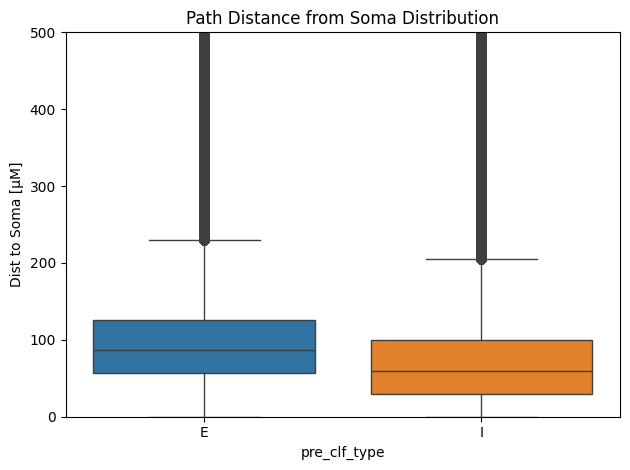

In [9]:
sns.boxplot(x="pre_clf_type", y="dist_to_post_syn_soma", hue="pre_clf_type", data=em_syn_df)
plt.title("Path Distance from Soma Distribution")
plt.ylim(0, 500);plt.ylabel("Dist to Soma [µM]")
plt.tight_layout();plt.show()

### Synapse Size

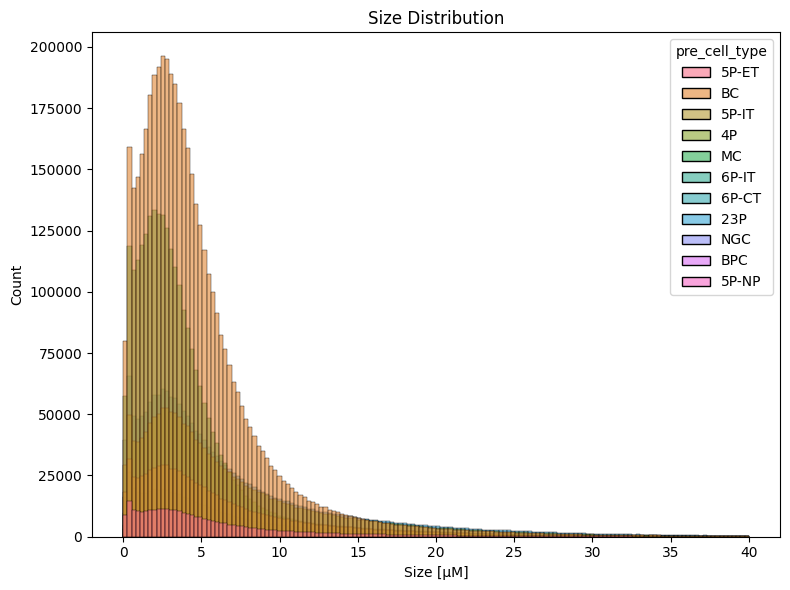

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=em_syn_df, x="size", hue="pre_cell_type",bins=150,
             multiple="layer", alpha=0.6, binrange=(0, 40), ax=ax)

ax.set_title("Size Distribution");ax.set_xlabel("Size [µM]");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

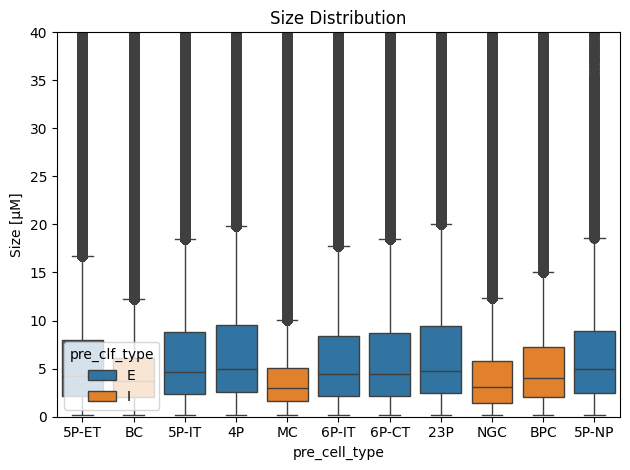

In [11]:
sns.boxplot(x="pre_cell_type", y="size", hue="pre_clf_type", data=em_syn_df)
plt.title("Size Distribution"); plt.ylabel("Size [µM]"),plt.ylim(0, 40)
plt.tight_layout();plt.show()

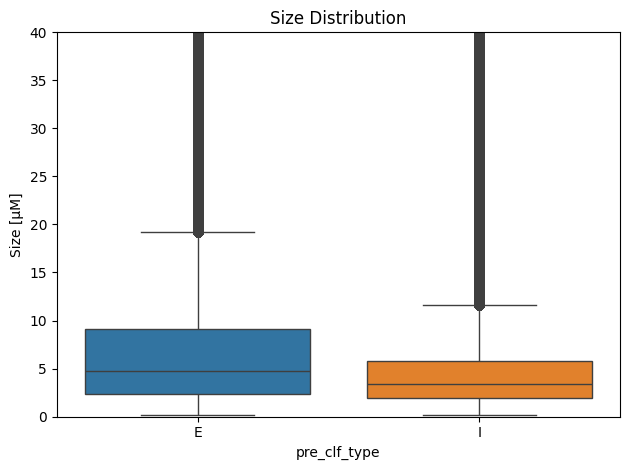

In [12]:
sns.boxplot(x="pre_clf_type", y="size", hue="pre_clf_type", data=em_syn_df)
plt.title("Size Distribution"); plt.ylabel("Size [µM]"),plt.ylim(0, 40)
plt.tight_layout();plt.show()

### Size vs. Dist to Soma

C:\Users\dean.geckt\Documents\Dendro-Synaptome\.venv_39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


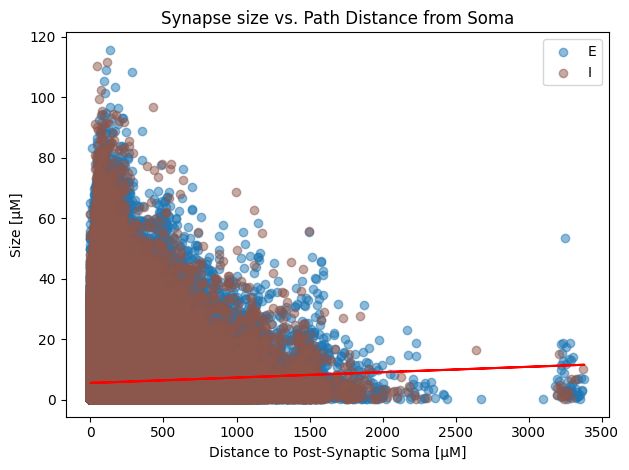

In [13]:
df = em_syn_df[['dist_to_post_syn_soma', 'size', 'pre_clf_type']]
X = df['dist_to_post_syn_soma']
y = df['size']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

unique_types = df['pre_clf_type'].unique()
color_map = plt.colormaps['tab10']
color_dict = {t: color_map(i/len(unique_types)) for i, t in enumerate(unique_types)}
for t in unique_types:
    mask = df['pre_clf_type'] == t
    plt.scatter(df.loc[mask, 'dist_to_post_syn_soma'], 
                df.loc[mask, 'size'], 
                alpha=0.5, 
                c=[color_dict[t]], 
                label=t)

plt.plot(df['dist_to_post_syn_soma'], model.predict(X), color='red')
plt.title("Synapse size vs. Path Distance from Soma"); plt.ylabel("Size [µM]"); plt.xlabel("Distance to Post-Synaptic Soma [µM]");
plt.tight_layout();plt.legend(); plt.show()